In [2]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

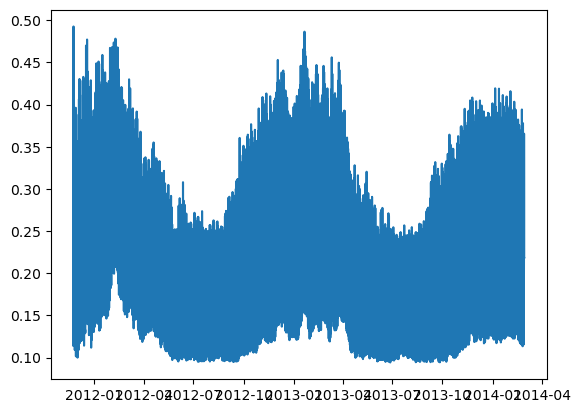

In [3]:
# Load the data
df = pd.read_csv('merged_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

df

#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

In [4]:
#check for break in timestamps
import pandas as pd

# Assuming df is your DataFrame and 'timestamp' is your timestamp column
df = df.sort_values('DateTime')

# Calculate the difference between current and previous timestamp
df['time_diff'] = df['DateTime'].diff()

# Define a threshold for a break, e.g., 1 hour
threshold = pd.Timedelta(hours=1)

# Check if there are any breaks
has_breaks = any(df['time_diff'] > threshold)

print(f"Data has breaks: {has_breaks}")

Data has breaks: False


In [5]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])


In [6]:
from river import datasets
from river import metrics
from river import time_series



model = time_series.HoltWinters(
    alpha=0.3,
    beta=0.1,
    gamma=0.6,
    seasonality=24,
    multiplicative=True
)

metric = metrics.MAE()

time_series.evaluate(
    stream,
    model,
    metric,
    horizon=24*7
)






+1   MAE: 6.770299
+2   MAE: 8.511204
+3   MAE: 9.603778
+4   MAE: 11.195775
+5   MAE: 14.029521
+6   MAE: 17.063814
+7   MAE: 22.754498
+8   MAE: 29.704472
+9   MAE: 39.083923
+10  MAE: 52.722283
+11  MAE: 23.227963
+12  MAE: 21.99927
+13  MAE: 24.218889
+14  MAE: 22.231712
+15  MAE: 28.426169
+16  MAE: 21.920653
+17  MAE: 27.552332
+18  MAE: 36.747208
+19  MAE: 42.361926
+20  MAE: 55.301264
+21  MAE: 33.790921
+22  MAE: 32.432322
+23  MAE: 22.641475
+24  MAE: 16.693599
+25  MAE: 32.122624
+26  MAE: 34.972129
+27  MAE: 33.895596
+28  MAE: 31.102884
+29  MAE: 35.432886
+30  MAE: 41.833498
+31  MAE: 53.478166
+32  MAE: 67.006262
+33  MAE: 89.532685
+34  MAE: 118.745314
+35  MAE: 53.252136
+36  MAE: 49.364565
+37  MAE: 52.855434
+38  MAE: 46.247508
+39  MAE: 54.855586
+40  MAE: 40.564197
+41  MAE: 49.724911
+42  MAE: 66.080993
+43  MAE: 76.102434
+44  MAE: 99.785996
+45  MAE: 60.862151
+46  MAE: 58.310167
+47  MAE: 41.001933
+48  MAE: 30.609762
+49  MAE: 58.951462
+50  MAE: 63.340886
+51

[0.08733573780648199, 0.23736084581770742, -0.07671562593139854, 0.03376606255922928, -0.3521425840214025, 0.08354477822983612, 0.342456863670497, -0.013468221496491023, 0.3204359587892842, -1.6791198885684324, -0.027689984107433143, 0.3135762021099269, -1.5112635572729924, -1.5473668549531485, -1.1322771265851523, 0.0034114978123597583, -4.594382862204842, -2.181517592542573, -1.9005851651805379, -1.2392072601170658, -38.76978706163065, -0.08913609248829969, -0.7915274028270988, 1.31269640982956, 0.38454498534169174, 0.9448039154908565, -0.28010498967336583, 0.11438166588321931, -1.116806602032372, 0.2499069902988088, 0.9721436667456401, -0.036470401136709636, 0.8313465104873086, -4.1895678629227735, -0.06666145437954123, 0.7304627050288405, -3.4149713488856226, -3.3993489028139283, -2.4230832867921257, 0.007124277714870271, -9.377610618546965, -4.358276732037649, -3.721325943758707, -2.3807873240303725, -73.16498550446424, -0.16539556728221896, -1.4454016233689249, 2.3610202068570234

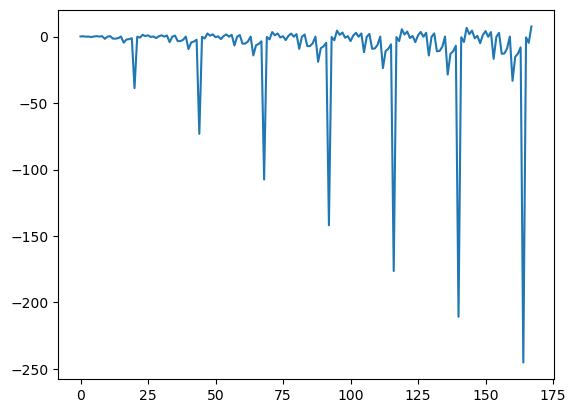

In [7]:
# Assume `model` is your trained HoltWinters model
# and `x_last` is the last known data point

predictions = model.forecast(horizon=24*7)

print(predictions)

# Plot the predictions
plt.plot(predictions)

In [9]:
from river import optim, evaluate, neighbors
from sklearn.model_selection import ParameterGrid
stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
# Define the parameter grid

learning_rate = [1,2,0.5,4,10,0.1]
NumberofNeighbeurs = [16,18,20]

param_grid = {'n_neighbors': NumberofNeighbeurs,
              'Aggregation_method': ['mean','median','weighted_mean'],
              'scaler': [preprocessing.StandardScaler(),preprocessing.AdaptiveStandardScaler(),preprocessing.MaxAbsScaler() , preprocessing.MinMaxScaler()],
              }

# Initialize the best MAE and learning rate
best_mae = float('inf')
best_lr = None


ListOfListOfPredictions = []
listofParams = []
# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    print(f'testing {params["n_neighbors"]} KNN with {params["Aggregation_method"]} Aggregation, {params["scaler"]} scaler')
    # Create a new model with the current learning rate
    model = compose.Pipeline(
        compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
        params['scaler'],
        preprocessing.TargetStandardScaler(
            regressor=neighbors.KNNRegressor(
                n_neighbors=params['n_neighbors'],
                aggregation_method = params['Aggregation_method'],
            )
        )
    )
    
    # Evaluate the model
    steps = evaluate.iter_progressive_val_score(
        dataset=stream,
        model=model.clone(),
        metric=metrics.MAE(),
        moment='DateTime',
        delay=dt.timedelta(days=7),
        step=1,
        yield_predictions=True,
    )
    
    

    stream = iter(df.itertuples(index=False))
    stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
    
    # Initialize lists to store the predictions and their timestamps
    predictions = []
    lastMean = 0
    for step in steps:
        predictions.append(step["Prediction"])
        lastMean = step["MAE"]
        
    ListOfListOfPredictions.append(predictions)
    listofParams.append(params)
    
    
    #print(float(str(mae).split(" ")[1]))
    # If the current MAE is better than the best MAE, update the best MAE and learning rate
    
    #convert mean to float
    print(lastMean)
    lastMean = float(str(lastMean).split(" ")[1])
    
    if lastMean != 0 and lastMean < best_mae:
        best_mae = lastMean
        best_lr = params['n_neighbors']
        bestAggregation_method = params['Aggregation_method']
        bestscaler = params['scaler']
        
        
 
print(f'Best MAE: {best_mae}')
print(f'Best Number of neighburs: {best_lr}')
print(f'Best Aggregation method: {bestAggregation_method}')
print(f'Best scaler: {bestscaler}')



#plotting of the predictions and actual values for a week

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')

for predictions,params in zip(ListOfListOfPredictions,listofParams):
	# Define the start and end dates
	start_date = pd.to_datetime('2013-01-01')
	end_date = start_date + pd.DateOffset(weeks=1)
	df['DateTime'] = pd.to_datetime(df['DateTime'])

	# Filter the data
	week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

	# Ensure the lists have the same length
	min_length = min(len(timestamps), len(predictions))
	print(len(timestamps))
	print(len(predictions))
	# Trim the lists to the minimum length
	timestamps = timestamps[:min_length]
	predictions = predictions[:min_length]

	# Now create the DataFrame
	df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

	#combine the predictions and timestamps into a dataframe
	df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

	#convert datetime to datetime object
	df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
	week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
	fig, ax = plt.subplots()

	# Also plot the actual values with transparency and a label for the legend
	ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

	# Plot the predictions with transparency and a label for the legend
	ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
	ax.set_ylabel('Energy Consumption (kWh)')
	ax.set_xlabel('Date')
	ax.legend()
	ax.set_title(f'{params["n_neighbors"]} KNN with {params["Aggregation_method"]}, {params["scaler"]}')

	# Rotate date labels automatically
	fig.autofmt_xdate()

	plt.show()





testing 16 KNN with mean Aggregation, StandardScaler scaler
MAE: 0.034151
testing 16 KNN with mean Aggregation, AdaptiveStandardScaler scaler
MAE: 0.05691
testing 16 KNN with mean Aggregation, MaxAbsScaler scaler
MAE: 0.035177
testing 16 KNN with mean Aggregation, MinMaxScaler scaler
MAE: 0.035065
testing 18 KNN with mean Aggregation, StandardScaler scaler
MAE: 0.034148
testing 18 KNN with mean Aggregation, AdaptiveStandardScaler scaler
MAE: 0.056718
testing 18 KNN with mean Aggregation, MaxAbsScaler scaler
MAE: 0.035055
testing 18 KNN with mean Aggregation, MinMaxScaler scaler
MAE: 0.035005
testing 20 KNN with mean Aggregation, StandardScaler scaler
MAE: 0.033708
testing 20 KNN with mean Aggregation, AdaptiveStandardScaler scaler
MAE: 0.056562
testing 20 KNN with mean Aggregation, MaxAbsScaler scaler
MAE: 0.034865
testing 20 KNN with mean Aggregation, MinMaxScaler scaler
MAE: 0.035071
testing 16 KNN with median Aggregation, StandardScaler scaler
MAE: 0.034071
testing 16 KNN with media

ValueError: All arrays must be of the same length